# Sentiment Analysis with Deep Learning using BERT

### Prerequisites

- Intermediate-level knowledge of Python 3 (NumPy and Pandas preferably, but not required)
- Exposure to PyTorch usage
- Basic understanding of Deep Learning and Language Models (BERT specifically)

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

## Introduction

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805).

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)

<img src="Images/BERT_diagrams.pdf" width="1000">

## Exploratory Data Analysis and Preprocessing

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

/var/folders/3z/gjs8159j4pj4fhckh__lk6g00000gn/T/ipykernel_40841/2097372332.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('/Users/mh/Downloads/LLM/smileannotationsfinal.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [3]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


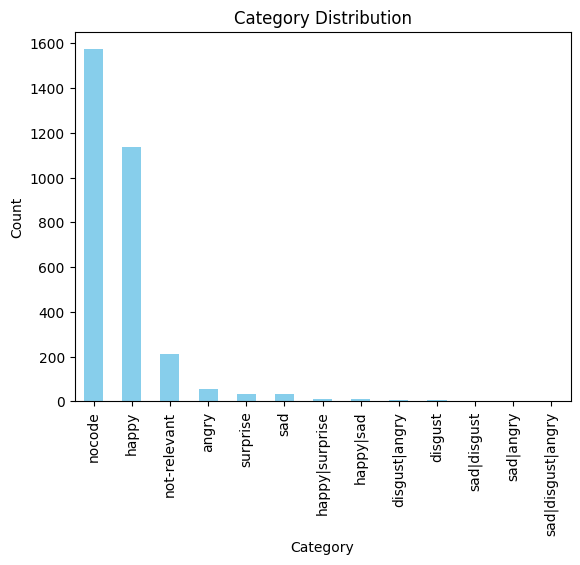

In [4]:
import matplotlib.pyplot as plt


category_counts = df['category'].value_counts()

category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


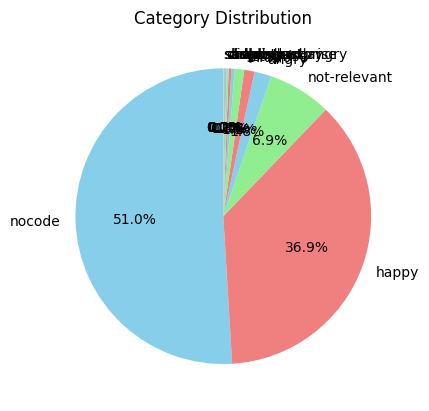

In [5]:
# plt.pie(category_counts)
# plt.show()

import matplotlib.pyplot as plt

category_counts = df['category'].value_counts()

plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Category Distribution')
plt.show()


In [6]:
df.category.value_counts()

category
nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: count, dtype: int64

In [7]:
df = df[~df.category.str.contains('\|')]

In [8]:
df = df[df.category != 'nocode']

In [9]:
df.category.value_counts()

category
happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: count, dtype: int64

In [10]:
possible_labels = df.category.unique()

In [11]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [12]:
df['label'] = df.category.replace(label_dict)

/var/folders/3z/gjs8159j4pj4fhckh__lk6g00000gn/T/ipykernel_40841/2696437164.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.category.replace(label_dict)


In [13]:
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


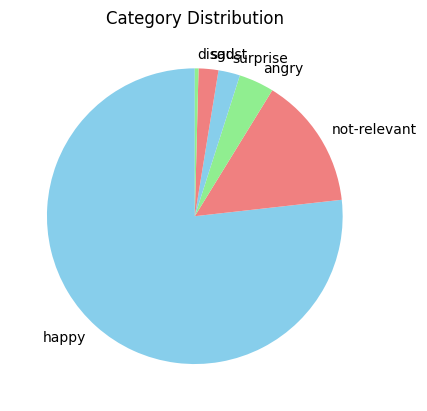

In [14]:
import matplotlib.pyplot as plt

category_counts = df['category'].value_counts()

plt.pie(category_counts, labels=category_counts.index, startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Category Distribution')
plt.show()

## Training/Validation Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  random_state=17,
                                                  stratify=df.label.values)

In [17]:
df['data_type'] = ['not_set']*df.shape[0]

In [18]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [19]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

## Loading Tokenizer and Encoding our Data

In [20]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [22]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [24]:
len(dataset_train)

1258

In [25]:
len(dataset_val)

223

## Setting up BERT Pretrained Model

In [26]:
from transformers import BertForSequenceClassification

In [27]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Data Loaders

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [29]:
batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [30]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [31]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [33]:
import numpy as np

In [34]:
from sklearn.metrics import f1_score

In [35]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [36]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [37]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [40]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [45]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [42]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
#model.load_state_dict(torch.load('Models/<<INSERT MODEL NAME HERE>>.model', map_location=torch.device('cpu')))

In [43]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [44]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 5/171

Class: not-relevant
Accuracy: 0/32

Class: angry
Accuracy: 9/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 0/5



In [5]:

def relabel_sentiment(category):
    if category in ['happy']:
        return 'Happy'
    else:
        return 'Unhappy'


df['sentiment'] = df['category'].apply(relabel_sentiment)

# Group by sentiment and sum counts
sentiment_counts = df.groupby('sentiment').sum().reset_index()

sentiment_counts

,sentiment,text,category
0,Happy,Dorian Gray with Rainbow Scarf #LoveWins (from...,happyhappyhappyhappyhappyhappyhappyhappyhappyh...
1,Unhappy,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocodenocodenocodenocodenocodenocodenocodenoco...


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

# Choose a pre-trained model for sentiment analysis (e.g., bert-base-uncased)
model_name = "bert-base-uncased"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 for binary sentiment

# Load a sentiment analysis dataset (replace with your data loading method)
train_data = load_dataset("imdb", split="train")

# Preprocess data (tokenization, label conversion)
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_data = train_data.map(preprocess_function, batched=True)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data["input_ids"], train_data["label"], test_size=0.2, random_state=42
)

# Create training and validation datasets
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True)
val_encodings = tokenizer(val_texts, padding="max_length", truncation=True)

# Training loop (adjust hyperparameters and training time as needed)
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",  # Output directory for checkpoints
    per_device_train_batch_size=16,  # Adjust batch size based on your GPU memory
    num_train_epochs=3,  # Adjust training epochs
    learning_rate=2e-5,  # Adjust learning rate
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
)

trainer.train()

# Save the fine-tuned model (optional)
trainer.save_model("./sentiment_model")

# Sentiment prediction on new text (example)
def predict_sentiment(text):
    inputs = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions.item()

new_text = "This movie was fantastic!"
predicted_sentiment = predict_sentiment(new_text)
print(f"Predicted sentiment for '{new_text}': {predicted_sentiment}")  # 0 for negative, 1 for positive

# Note: This is a simplified example. Training LLMs can be complex and requires significant resources.


ModuleNotFoundError: No module named 'datasets'